### Data Preparation & Enviroment Setup

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

transactions = pd.read_csv('TRANSACTION_TAKEHOME.csv')
product = pd.read_csv('PRODUCTS_TAKEHOME.csv')
user = pd.read_csv('USER_TAKEHOME.csv')

## Data Exploration
### TRANSACTION_TAKEHOME.csv

In [4]:
# This is the first 10 rows of data, we can get to see the basic sense of the data
transactions.head(5)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21 14:19:06.539 Z,WALMART,63b73a7f3d310dceeabd4758,1.530001e+10,1.00,
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20 09:50:24.206 Z,ALDI,62c08877baa38d1a1f6c211a,NaN,zero,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19 15:38:56.813 Z,WALMART,60842f207ac8b7729e472020,7.874223e+10,1.00,
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19 11:03:37.468 Z,FOOD LION,63fcd7cea4f8442c3386b589,7.833997e+11,zero,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05 15:56:43.549 Z,RANDALLS,6193231ae9b3d75037b0f928,4.790050e+10,1.00,


In [5]:
# Display the data structure of the data frame
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RECEIPT_ID      50000 non-null  object 
 1   PURCHASE_DATE   50000 non-null  object 
 2   SCAN_DATE       50000 non-null  object 
 3   STORE_NAME      50000 non-null  object 
 4   USER_ID         50000 non-null  object 
 5   BARCODE         44238 non-null  float64
 6   FINAL_QUANTITY  50000 non-null  object 
 7   FINAL_SALE      50000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.1+ MB


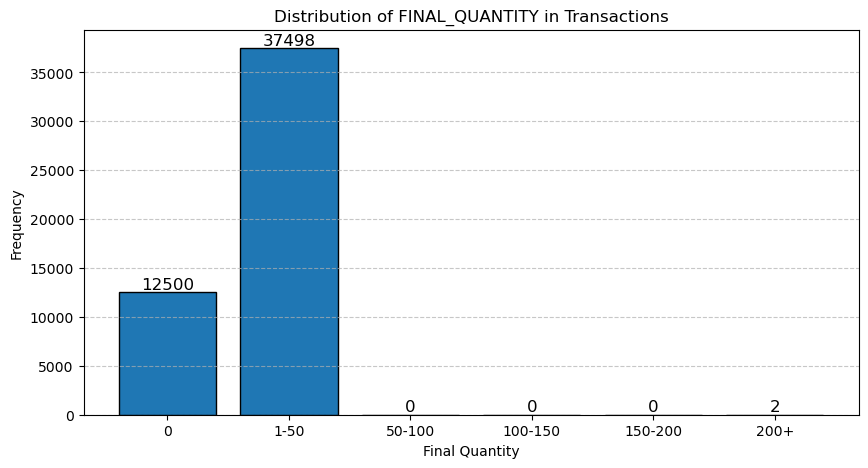

In [6]:
transactions['FINAL_QUANTITY'] = transactions['FINAL_QUANTITY'].replace("zero", 0)
transactions['FINAL_QUANTITY'] = pd.to_numeric(transactions['FINAL_QUANTITY'], errors='coerce')
transactions = transactions.dropna(subset=['FINAL_QUANTITY'])

# Plot histogram of FINAL_QUANTITY
bins = [-1, 0, 50, 100, 150, 200, float('inf')]
labels = ['0', '1-50', '50-100', '100-150', '150-200', '200+']
transactions['FINAL_BINNED'] = pd.cut(transactions['FINAL_QUANTITY'], bins=bins, labels=labels)
value_counts = transactions['FINAL_BINNED'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(value_counts.index, value_counts.values, edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)
    
plt.xlabel('Final Quantity')
plt.ylabel('Frequency')
plt.title('Distribution of FINAL_QUANTITY in Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

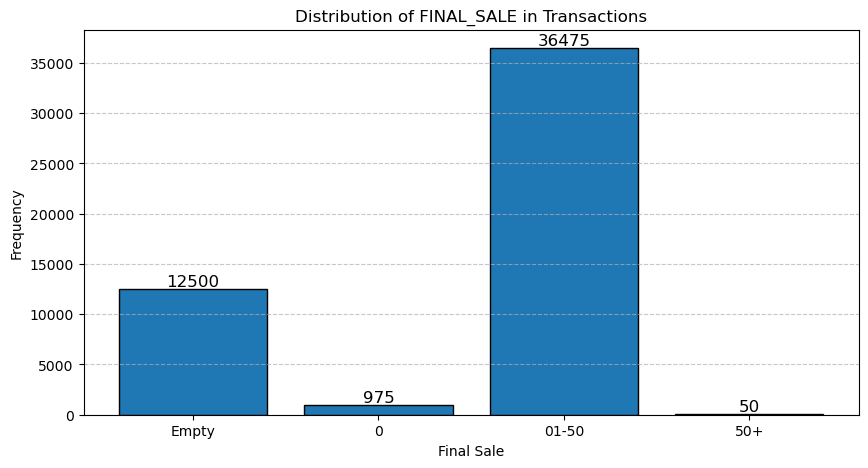

In [7]:
# Fill the empty space to -1
transactions['FINAL_SALE'] = transactions['FINAL_SALE'].replace(" ",'-1')
#Convert datatype to numeric
transactions['FINAL_SALE'] = pd.to_numeric(transactions['FINAL_SALE'])

# Plot histogram of FINAL_SALE
bins = [-2, -0.5,0.5, 50, float('inf')]
# Create label for histogram interval
labels = ['Empty','0','0' '1-50', '50+']
# Data Visulization
transactions['FINAL_SALE_BINNED'] = pd.cut(transactions['FINAL_SALE'], bins=bins, labels=labels, right=True, include_lowest=True)
value_counts = transactions['FINAL_SALE_BINNED'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
bars = plt.bar(value_counts.index, value_counts.values, edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)
    
plt.xlabel('Final Sale')
plt.ylabel('Frequency')
plt.title('Distribution of FINAL_SALE in Transactions')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### Finding: 
1. The column of the barcode contains null values.
2. The data type of the "final_quantity" and "final_sale" are objects, which means it contain values other than numeric types.
3. Based on the distribution plot, we find that the "final_sale" contains 0 and is empty when the receipts are scanned. We need to verify the data quality.

### Data Cleaning for Transactions Dataset
##### Assumption: When multiple rows share the same RECEIPT_ID, BARCODE, and USER_ID but have inconsistent values in FINAL_QUANTITY or FINAL_SALE, we assume these discrepancies stem from data entry errors or incomplete records. To ensure data consistency, we convert "zero" in FINAL_QUANTITY to 0 and treat empty FINAL_SALE values as missing data. This approach enables proper aggregation, improves duplicate removal, and ensures we retain the most accurate records. Without external verification, these assumptions allow us to derive the best possible analysis outcomes from the available data.

In [10]:
# Removal of data that FINAL_SALE have null value
transactions = transactions[transactions['FINAL_SALE'] != -1]
# Removal of data that FINAL_QUANTITY have value of zero
transactions = transactions[transactions['FINAL_QUANTITY'] != 0]
# Check for duplicated datas
duplicate = transactions[transactions.duplicated(keep=False)]
duplicate.shape[0]

276

In [11]:
# Removal of duplicated rows of data and keep the first data
transactions = transactions.drop_duplicates(keep='first')
# Double check duplicated rows of data
transactions[transactions.duplicated(keep=False)]

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE,FINAL_BINNED,FINAL_SALE_BINNED


In [12]:
transactions.drop(columns=['FINAL_BINNED', 'FINAL_SALE_BINNED'], errors='ignore',inplace=True)
#Updated version of transaction dataset. This dataset is well-formated datatypes and does not have a null entry. 
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24852 entries, 25000 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RECEIPT_ID      24852 non-null  object 
 1   PURCHASE_DATE   24852 non-null  object 
 2   SCAN_DATE       24852 non-null  object 
 3   STORE_NAME      24852 non-null  object 
 4   USER_ID         24852 non-null  object 
 5   BARCODE         21996 non-null  float64
 6   FINAL_QUANTITY  24852 non-null  float64
 7   FINAL_SALE      24852 non-null  float64
dtypes: float64(3), object(5)
memory usage: 1.7+ MB


####
####
### PRODUCT_TAKEHOME.csv

In [14]:
# This is the first 5 rows of product data, we can get to see the basic sense of the data
product.head(5)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE
0,Health & Wellness,Sexual Health,Conductivity Gels & Lotions,NaN,NaN,NaN,7.964944e+11
1,Snacks,Puffed Snacks,Cheese Curls & Puffs,NaN,NaN,NaN,2.327801e+10
2,Health & Wellness,Hair Care,Hair Care Accessories,NaN,PLACEHOLDER MANUFACTURER,ELECSOP,4.618178e+11
3,Health & Wellness,Oral Care,Toothpaste,NaN,COLGATE-PALMOLIVE,COLGATE,3.500047e+10
4,Health & Wellness,Medicines & Treatments,Essential Oils,NaN,MAPLE HOLISTICS AND HONEYDEW PRODUCTS INTERCHA...,MAPLE HOLISTICS,8.068109e+11


In [15]:
# Display the data structure of the dataframe
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CATEGORY_1    845441 non-null  object 
 1   CATEGORY_2    844128 non-null  object 
 2   CATEGORY_3    784986 non-null  object 
 3   CATEGORY_4    67459 non-null   object 
 4   MANUFACTURER  619078 non-null  object 
 5   BRAND         619080 non-null  object 
 6   BARCODE       841527 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.2+ MB


#### Finding:
- Missing value and null value on fields, category / manufacturer / brand / barcode. These missing values can create challenges in accurately linking products to transactions, potentially leading to unmatchable records in the transaction data.

In [17]:
print(f'''CATEGORY_1 contains {product['CATEGORY_1'].dropna().nunique()} distinct categories,\n
CATEGORY_2 contains {product['CATEGORY_2'].dropna().nunique()} distinct categories,\n
CATEGORY_3 contains {product['CATEGORY_3'].dropna().nunique()} distinct categories,\n 
CATEGORY_4 contains {product['CATEGORY_4'].dropna().nunique()} distinct categories,\n
MANUFACTURER contains {product['MANUFACTURER'].dropna().nunique()} distinct manufactures,\n
BRAND contains {product['BRAND'].dropna().nunique()} distinct brands  ''')

CATEGORY_1 contains 27 distinct categories,

CATEGORY_2 contains 121 distinct categories,

CATEGORY_3 contains 344 distinct categories,
 
CATEGORY_4 contains 127 distinct categories,

MANUFACTURER contains 4354 distinct manufactures,

BRAND contains 8122 distinct brands  


### Data Cleaning for Product Dataset

In [19]:
# Convert the category with null value to the unknow
product['CATEGORY_1'] = product['CATEGORY_1'].fillna("unknow")
product['CATEGORY_2'] = product['CATEGORY_2'].fillna("unknow")
product['CATEGORY_3'] = product['CATEGORY_3'].fillna("unknow")
product['CATEGORY_4'] = product['CATEGORY_4'].fillna("unknow")
product['MANUFACTURER'] = product['MANUFACTURER'].fillna("unknow")
product['BRAND'] = product['BRAND'].fillna("unknow")

In [20]:
# Double check if the category still contain null values
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CATEGORY_1    845552 non-null  object 
 1   CATEGORY_2    845552 non-null  object 
 2   CATEGORY_3    845552 non-null  object 
 3   CATEGORY_4    845552 non-null  object 
 4   MANUFACTURER  845552 non-null  object 
 5   BRAND         845552 non-null  object 
 6   BARCODE       841527 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.2+ MB


####
####
### USER_TAKEHOME.csv

In [22]:
# This is the first 10 rows of user data, we can get to see the basic sense of the data
user.head(10)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24 20:17:54.000 Z,2000-08-11 00:00:00.000 Z,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03 19:53:55.000 Z,2001-09-24 04:00:00.000 Z,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31 18:42:18.000 Z,1994-10-28 00:00:00.000 Z,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26 01:46:22.000 Z,NaN,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28 11:51:50.000 Z,1972-03-19 00:00:00.000 Z,PA,en,female
5,5fe2b6f3ad416a1265c4ab68,2020-12-23 03:18:11.000 Z,1999-10-27 04:00:00.000 Z,NY,en,female
6,651210546816bb4d035b1ead,2023-09-25 22:57:24.000 Z,1983-09-25 22:57:25.000 Z,FL,es-419,male
7,642831ea3d4434e63c1936fd,2023-04-01 13:30:18.000 Z,1970-02-16 05:00:00.000 Z,IN,en,female
8,63a4c9a1b5f32149b9d82f9e,2022-12-22 21:18:25.000 Z,1982-12-22 05:00:00.000 Z,NC,en,female
9,63654b21d02459d8a57a2e2c,2022-11-04 17:25:53.000 Z,1992-05-03 04:00:00.000 Z,NY,en,non_binary


In [23]:
user['GENDER'].unique()

array(['female', nan, 'male', 'non_binary', 'transgender',
       'prefer_not_to_say', 'not_listed', 'Non-Binary', 'unknown',
       'not_specified', "My gender isn't listed", 'Prefer not to say'],
      dtype=object)

In [24]:
# Display the data structure of the data frame
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ID            100000 non-null  object
 1   CREATED_DATE  100000 non-null  object
 2   BIRTH_DATE    96325 non-null   object
 3   STATE         95188 non-null   object
 4   LANGUAGE      69492 non-null   object
 5   GENDER        94108 non-null   object
dtypes: object(6)
memory usage: 4.6+ MB


#### Finding:
- Missing values in the fields, birth date/state/language/gender. For the entry of gender, it contains redundant categories, like "unknown", "not_specified", and "My gender isn't listed" may overlap.

In [26]:
f'The earliest user creation time is {user['CREATED_DATE'].min()}. The most recent user creation date is {user['CREATED_DATE'].max()}'

'The earliest user creation time is 2014-04-18 23:14:55.000 Z. The most recent user creation date is 2024-09-11 17:59:15.000 Z'

In [27]:
f'The oldest user is {user['BIRTH_DATE'].dropna().min()}. The youngest user creation date is {user['BIRTH_DATE'].dropna().max()}'

'The oldest user is 1900-01-01 00:00:00.000 Z. The youngest user creation date is 2022-04-03 07:00:00.000 Z'

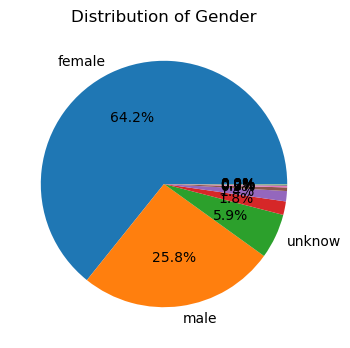

In [28]:
gender_counts_all = user['GENDER'].value_counts(dropna=False)

# Replace NaN with "Unknown" for better visualization
gender_counts_all.index = gender_counts_all.index.fillna("unknow")

# Only create label male/female / unknown, as we trying to keep the best effect of data visualization 
labels = [g if g in ["male", "female", "unknow"] else "" for g in gender_counts_all.index]

plt.figure(figsize=(6, 4))
plt.pie(gender_counts_all, labels=labels, autopct=lambda p: f'{p:.1f}%' if p > 0 else '')
plt.title("Distribution of Gender")
plt.show()

## SQL Queries
#### <span style="color:blue">1. What are the top 5 brands by receipts scanned among users 21 and over?
##### Based on the provided transaction records, we could find that  COCA-COLA / GREAT VALUE / PEPSI / EQUATE / LAY'S top 5 brands by receipts scanned among users 21 and over. Please find the result under the SQL query.


In [30]:
conn = sqlite3.connect(":memory:")

user.to_sql("table1", conn, index=False, if_exists="replace")
product.to_sql("table2", conn, index=False, if_exists="replace")
transactions.to_sql("table3", conn, index=False, if_exists="replace")

query = """WITH t1 AS (
    SELECT BARCODE,
            BRAND
    FROM table2),

    t2 AS (
        SELECT ID
        FROM table1
        WHERE (julianday('now') - julianday(BIRTH_DATE)) / 365.25 >= 21),

    t3 AS (
        SELECT t1.BRAND,
            COUNT(table3.RECEIPT_ID)AS number_receipt
        FROM table3 
        JOIN t1 ON table3.BARCODE = t1.BARCODE
        LEFT JOIN t2 ON t2.ID = table3.USER_ID
        GROUP BY t1.BRAND)

    SELECT * 
    FROM t3
    ORDER BY number_receipt DESC LIMIT 6"""

#t1 is the CTE to select the data
#t2 is the CTE to find the users 21 and over
#t3 is the CTE aggregate the number of receipts scanned by the selective users

df_result = pd.read_sql(query, conn)
print(df_result)

         BRAND  number_receipt
0    COCA-COLA             535
1  GREAT VALUE             384
2       unknow             366
3        PEPSI             364
4       EQUATE             341
5        LAY'S             324


#### <span style="color:blue"> 2. What are the top 5 brands by sales among users that have had their account for at least six months?
##### Based on the provided transaction records, we could find that  PEPSI / COCA-COLA / EQUATE / GREAT VALUE / HERSHEY'S are the top 5 brands by sales among users that have had their account for at least six months. Please find the result under the SQL query.

In [32]:
query = """WITH t1 AS
        (SELECT DISTINCT ID
         FROM table1
        WHERE (julianday('now') - julianday(CREATED_DATE)) >= 180),

        t2 AS (
        SELECT df2.BRAND,
            df3.BARCODE,
            df3.RECEIPT_ID,
            df3.USER_ID,
            df3.FINAL_QUANTITY,
            df3.FINAL_SALE
        FROM table2 df2
        JOIN table3 df3 ON df2.BARCODE = df3.BARCODE
        LEFT JOIN t1 ON df3.USER_ID = t1.ID 

        ),

        t3 AS (
        SELECT t2.BRAND, 
            COUNT(t2.RECEIPT_ID) AS num_receipts, 
            SUM(t2.FINAL_QUANTITY*t2.FINAL_SALE) AS total_sales
        FROM t2
        GROUP BY t2.BRAND  
        ORDER BY total_sales DESC  
        LIMIT 6
        )
        SELECT *
        FROM t3"""

#t1 is the CTE to define the account created for at least 6 months
#t2 is the CTE to filter the data in the 6 month period and join the transactions record on barcode
#t3 is the CTE to aggregate the sum of sales for each brand

df_result = pd.read_sql(query, conn)
print(df_result)

         BRAND  num_receipts  total_sales
0        PEPSI           364    3821.3728
1    COCA-COLA           535    3203.6575
2       unknow           366    2449.8067
3       EQUATE           341    2084.1700
4  GREAT VALUE           384    1778.0600
5    HERSHEY'S           190    1430.6771


#### <span style="color:blue"> 3. What is the percentage of sales in the Health & Wellness category by generation?
##### I divided the generation into 6 groups. The oldest fetch user was born in 1900 based on my exploratory data analysis. 
##### Group1(1944 Forward) / Group2(1944-1965) / Group3(1965-1980)/ Group4(1980-1995) / Group5(1995-2010) / Group6(2010-Now)
##### Based on the transaction record, 49.71% of sales come from Group2(1944-1965), 30.09% of sales come from group3(1965-1980), 20.2% of sales come from group4(1980-1995)

In [34]:
query = """WITH t1 AS
        (SELECT ID,
        birth_year,
        CASE
            WHEN birth_year<1944 THEN 'group1(1944 Forward)'
            WHEN birth_year>=1944 AND birth_year<1965 THEN 'group2(1944-1965)'
            WHEN birth_year>=1965 AND birth_year<1980 THEN 'group3(1965-1980)'
            WHEN birth_year>=1980 AND birth_year<1995 THEN 'group4(1980-1995)'
            WHEN birth_year>=1995 AND birth_year<2010 THEN 'group5(1995-2010)'
            WHEN birth_year>=2010 THEN 'group6(2010-Now)'
            ELSE 'none'
        END AS 'generation'
        FROM(SELECT ID,
             strftime('%Y', BIRTH_DATE)+0 AS birth_year
             FROM table1)
         WHERE birth_year != 'none'), 

        t2 AS (
        SELECT t1.generation,
            df3.FINAL_QUANTITY,
            df3.FINAL_SALE
        FROM table2 df2
        JOIN table3 df3 ON df2.BARCODE = df3.BARCODE
        JOIN t1 ON df3.USER_ID = t1.ID
        WHERE df2.CATEGORY_1 = 'Health & Wellness'
        ),

        t3 AS (
        SELECT t2.generation,
           SUM(t2.FINAL_SALE * t2.FINAL_QUANTITY) AS total_sales
        FROM t2
        GROUP BY t2.generation
        ),

        t4 AS (
            SELECT SUM(total_sales) AS grand_total
        FROM t3
        )

        SELECT t3.generation,
           t3.total_sales,
           ROUND((t3.total_sales * 100.0 / t4.grand_total), 2) AS percentage_of_sales
        FROM t3
        JOIN t4 ON 1=1
        ORDER BY t3.total_sales DESC;"""

#t1 is the CTE to define the generation
#t2 is the CTE to filter the data in 'Health & Wellness' and join the user ID data in the generation
#t3 is the CTE to aggregate the total sales for each generation that have transactions on the current record
#t4 is the CTE to aggregate the total sales for all generations that have transactions on the current record
#SQL query to calculate the percentage of sales for each generation

df_result = pd.read_sql(query, conn)
print(df_result)

          generation  total_sales  percentage_of_sales
0  group2(1944-1965)        86.56                49.71
1  group3(1965-1980)        52.39                30.09
2  group4(1980-1995)        35.17                20.20


#### <span style="color:blue"> 4. Which is the leading brand in the Dips & Salsa category?
##### Based on the provided transaction records, we could find that TOSTITOS is the leading brand in the Dips & Salsa category which has the most scanned receipts and sales. Please find the result under the SQL query.

In [36]:
query = """
WITH t1 AS(
    SELECT BARCODE,
        BRAND,
        category_2
    FROM table2
    WHERE category_2 LIKE 'Dips & Salsa'
    ),

t2 AS(
    SELECT txt1.receipt_id,
        t1.BRAND,
        (txt1.final_quantity*txt1.final_sale)AS sale
    FROM table3 txt1
    JOIN t1 ON txt1.barcode = t1.barcode
    ORDER BY 1,2
    ),

t3 AS(
    SELECT brand,
        COUNT(receipt_id) AS receipt_count,
        SUM(sale) AS total_sales
    FROM t2
    GROUP BY brand
)

select * 
from t3
order by receipt_count DESC, total_sales DESC
LIMIT 10"""

#t1 is the CTE to find the brand in the Dips & Salsa category
#t2 is the CTE to aggregate the sum of the sales for each brand record in the Dips & Salsa category
#t3 is the CTE to aggregate the number of receipts and the sum of the sales for each brand
#Order the t3 receipt_count & total_sales

df_result = pd.read_sql(query, conn)
print(df_result)

                  brand  receipt_count  total_sales
0              TOSTITOS             36       197.24
1                  PACE             24        85.75
2                unknow             21       107.21
3                FRITOS             19        73.76
4      DEAN'S DAIRY DIP             17        39.95
5            MARKETSIDE             16        65.22
6          HELUVA GOOD!             15        53.98
7  FRESHNESS GUARANTEED             12        46.66
8              MARZETTI             11        51.14
9         HIDDEN VALLEY             10        76.38


## Communication with stakeholders

Dear Mr./Mrs,

I hope this message finds you well. I am reaching out to share insights from my exploratory data analysis and to highlight key data quality issues that require further discussion and resolution.

After my exploratory data analysis, there are 3 major data quality issues have been identified.
1. Missing Data
   
   For "PRODUCTS_TAKEHOME.csv" has missing values in the category, manufacture, and barcode information. <br>For "UERS_TAKEHOME.csv" has missing values in the information of birth date, state, language, and gender.<br>For "TRANSACTIONS_TAKEHOME.csv" has missing values in the information of barcode.

   

2. Inconsistent Data Types

   For "TRANSACTIONS_TAKEHOME.csv", the column of 'FINAL_QUANTITY' contains non-numeric values like "zero". The column of 'FINAL_SALE' contains many rows of blank space data, making it difficult to determine transaction amounts.

3. Potential of Duplicate Data in "TRANSACTIONS_TAKEHOME.csv"

    We found that 50,000 rows in the dataset contain duplicate records when checking the rows: RECEIPT_ID, PURCHASE_DATE, SCAN_DATE, STORE_NAME, USER_ID, and BARCODE.

Based on the SQL query investigation, we found that Coca-Cola and Pepsi are the 2 brands that ranked high in the loyal Fetch user and 21+ years old Fetch users. In other words, these 2 brands have a long-term rewards points campaign event in Fetch Rewards. 

In addition to that I would like to address my questions and potential solutions for the outstanding issues,
1. Unknown brand and category classification

   Resolution: Can we verify the data and provide the reference data for the unknown products? Before verification, I propose standardizing all unknown brands and categories by overwriting them as "unknown" for consistency.

2. Change of FINAL_SALE & FINAL_QUANTITY for transactions data

   Resolution: Can we confirm if "zero" values and blank spaces represent actual data? However, before we verify the data, I would like to overwrite the 'zero' to integer 0 for numeric consistency. Also, I would like to overwrite the " " to integer 0.

3. Duplicated Data

   Resolution: Can we verify if duplicate transactions should be merged or if they result from ingestion errors?(check for FINAL_SALE & FINAL_QUANTITY) and merge the duplicate row? Before verification, I would like to drop the data that have 'zero' in 'FINAL_QUANTITY' and " "(empty space) in 'FINAL_SALE'. Since we could not make any assumption based on the unknown situation. Lastly, we need to review duplicate rows that occur more than twice and retain only the first occurrence in the dataset.

I am looking forward to hearing your thoughts and clarifications. Please let me know how you'd like to proceed, and I’d be happy to make any necessary adjustments.


Best Regards,

Xinghong Ma

